In [1]:
import csv
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

from tqdm.auto import tqdm
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

BATCH_SIZE = 15
CROP_SIZE = 224
IMAGE_SHAPE = (128, 128)
PROCESSED_DATASET_PATH_MNETV1_TRAIN = Path("../../../dataset/processed/awa2/mnetv1/train")
PROCESSED_DATASET_PATH_MNETV1_TEST = Path("../../../dataset/processed/awa2/mnetv1/test/")
PROCESSED_DATASET_PATH_MNETV1_VAL = Path("../../../dataset/processed/awa2/mnetv1/val")


print(device)

cuda:0


In [2]:
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_TRAIN, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_VAL, transform=test_transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

test_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_VAL, transform=test_transform)
test_loader = DataLoader(test_set, shuffle=True)

print(len(train_set), len(val_set), len(test_set), train_set.classes)

10805 1346 1346 ['antelope', 'cow', 'deer', 'elephant', 'giraffe', 'horse', 'lion', 'rabbit', 'sheep', 'squirrel', 'zebra']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


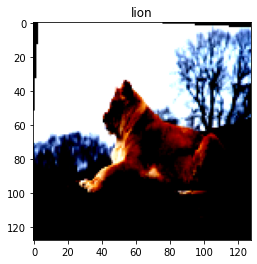

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


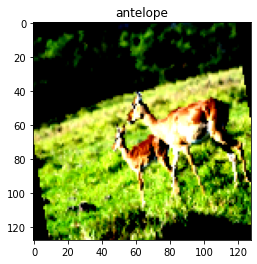

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


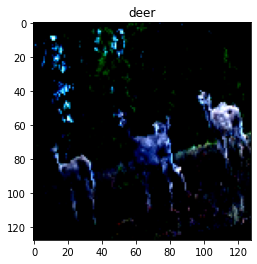

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


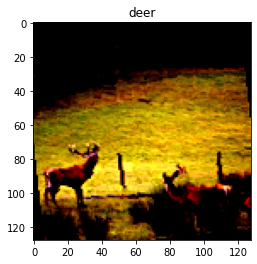

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


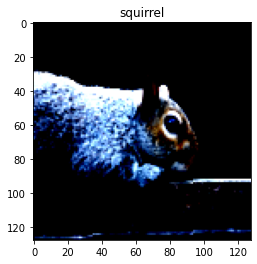

In [3]:
train_loader_vis = torch.utils.data.DataLoader(train_set, 15, shuffle=True)

images, labels = next(iter(train_loader_vis))
images, labels = images.numpy() , labels.numpy()

for i in range(5):
    plt.imshow(np.transpose(images[i] , (1,2,0)))
    plt.title(train_set.classes[labels[i]])
    plt.show()

del images, labels
del train_loader_vis

In [4]:
model = torchvision.models.mobilenet_v2(num_classes=len(train_set.classes), pretrained=False)
model = model.to(device)
model.eval()

c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [5]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
open("./logs/training_logs.csv", "w", newline="")
log_file = open("./logs/training_logs.csv", "a", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])


def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == 'train':
        model.train()
    elif mode == 'val':
        model.eval()
  
    loss = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        loss += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    loss = loss/len(dataset)
    accuracy = correct/len(dataset)
    return loss, accuracy

num_epochs = 30
try:
    for epoch in range(1, num_epochs + 1):
        train_cost, train_score = loop_fn('train', train_set, train_loader, model, criterion, optimizer)
        with torch.no_grad():
            test_cost, test_score = loop_fn('val', val_set, val_loader, model, criterion, optimizer)
        print(epoch, float(train_cost), train_score, float(test_cost), test_score)
        csv_writer.writerow([epoch, float(train_cost), train_score, float(test_cost), test_score])
        torch.save(model.state_dict(), f"./logs/models/model_e{epoch}.pth")
except Exception as e:
    log_file.close()
    raise e


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

1 0.001453287317417562 0.24562702452568255 0.015912611037492752 0.36701337295690933


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

2 0.0009556076256558299 0.3726052753354928 0.011035238392651081 0.4011887072808321


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

3 0.0005774630117230117 0.43202221193891716 0.010914492420852184 0.4739970282317979


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

4 0.0010014238068833947 0.49264229523368813 0.011448350735008717 0.4866270430906389


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

5 0.0005148554337210953 0.5471540953262378 0.008672649972140789 0.5973254086181278


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

6 0.000781340291723609 0.5911152244331328 0.01687484234571457 0.5943536404160475


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

7 0.0011407769052311778 0.6201758445164276 0.01588595099747181 0.6084695393759286


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

8 0.000441397016402334 0.6631189264229523 0.007143403869122267 0.6783060921248143


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

9 0.000882502761669457 0.6936603424340583 0.01650763675570488 0.6924219910846954


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

10 0.0010197400115430355 0.7109671448403517 0.005122436210513115 0.7095096582466568


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

11 0.0005095240194350481 0.7302174919018972 0.005233884789049625 0.7414561664190193


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

12 0.0010270271450281143 0.7522443313280889 0.0010954475728794932 0.763001485884101


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

13 0.0007014351431280375 0.7664969921332716 0.0012742414837703109 0.7592867756315007


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

14 0.0007387202931568027 0.7815826006478482 0.0036774335894733667 0.7295690936106983


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

15 0.0004695270035881549 0.7850069412309116 0.004051063675433397 0.7956909361069836


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

16 0.0002072620263788849 0.8017584451642757 0.01209912821650505 0.7726597325408618


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

17 0.0006809120532125235 0.808792225821379 0.0019070495618507266 0.8053491827637445


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

18 0.00014849973376840353 0.8220268394261916 0.0107053117826581 0.788261515601783


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

19 0.0010865293443202972 0.8232299861175382 0.0013948546256870031 0.8060921248142645


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

20 0.0004085166146978736 0.8415548357242018 0.0038637707475572824 0.8231797919762258


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

21 0.00017035625933203846 0.8443313280888478 0.002455957932397723 0.8358098068350669


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

22 0.0003235137846786529 0.8492364645997224 0.0054461769759655 0.8016344725111442


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

23 0.0010069721611216664 0.8563627950023137 0.006735578179359436 0.8320950965824666


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

24 0.00021699079661630094 0.8660805182785747 0.005446251016110182 0.8246656760772659


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

25 0.00011894394992850721 0.86941230911615 0.004241602960973978 0.8447251114413076


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

26 0.00036343943793326616 0.8798704303563165 0.012658728286623955 0.8216939078751857


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

27 1.3522670087695587e-05 0.8776492364645997 0.0032030101865530014 0.8350668647845468


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

28 0.0006818647379986942 0.885145765849144 0.00795725453644991 0.8283803863298663


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

29 0.0009313230984844267 0.890698750578436 0.0036284278612583876 0.8380386329866271


Train:   0%|          | 0/721 [00:00<?, ?it/s]

Val:   0%|          | 0/90 [00:00<?, ?it/s]

30 0.000382034108042717 0.8909763998149005 0.008908841758966446 0.837295690936107


In [9]:
with torch.no_grad():
    test_cost, test_score = loop_fn('val', test_set, test_loader, model, criterion, optimizer)
print(f"Testing Loss = {test_cost}, Accuracy = {test_score}")

Val:   0%|          | 0/1346 [00:00<?, ?it/s]

Testing Loss = 4.251142549094311e-09, Accuracy = 0.837295690936107


In [13]:

y_pred = []
y_true = []

test_loader2 = DataLoader(test_set, shuffle=True)
for images, labels in test_loader2:
        output = np.squeeze(model(images.cuda()).data.max(1, keepdim=True)[1].cpu().numpy())
        y_pred.extend([output])
        
        labels = labels.data.cpu().numpy()
        y_true.extend([labels])

from sklearn.metrics import accuracy_score, classification_report


print("Overall Accuracy: ", round(accuracy_score(y_true, y_pred)*100,2)," %")
print(classification_report(y_true, y_pred,target_names=train_set.classes))

Overall Accuracy:  83.73  %
              precision    recall  f1-score   support

    antelope       0.70      0.86      0.77       104
         cow       0.71      0.74      0.73       133
        deer       0.72      0.69      0.70       134
    elephant       0.88      0.96      0.92       103
     giraffe       0.97      0.95      0.96       120
       horse       0.86      0.70      0.77       164
        lion       0.91      0.82      0.86       101
      rabbit       0.85      0.93      0.88       108
       sheep       0.85      0.82      0.84       142
    squirrel       0.83      0.88      0.86       120
       zebra       0.97      0.97      0.97       117

    accuracy                           0.84      1346
   macro avg       0.84      0.85      0.84      1346
weighted avg       0.84      0.84      0.84      1346

